# Congressional Record and Hansard Analysis


This notebook contains the analysis of the Congressional Record and Hansard datasets.


## Setup


In [3]:
import ssl

import nltk
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt

# Ignore SSL certificate errors
ssl._create_default_https_context = ssl._create_unverified_context

nltk.download('punkt')
nltk.download('stopwords')

congressional_record_path = '../congressional-record/dist/'
hansard_path = '../hansard-in-full/'
climate_dictionary_path = 'dictionaries/'

data_path = 'data/'
dist_path = 'dist/'

/var/folders/g4/5xzy77v17m1fbt0xq_sn3f140000gn/T/ipykernel_63535/1298019756.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/felixwallis/Desktop/UCL Politics and International Relations Course/Dissertation/pir-dissertation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/felixwallis/nltk_data...
[nltk_data]   Package punkt is already up-t

## Preprocessing


**Preprocessing functions for the Congressional Record and Hansard**


In [8]:
stop_words = set(stopwords.words('english'))


def clean_tokenize(text):
    # Text should almost always be a string, but we check
    # just in case
    if not isinstance(text, str):
        text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation, numbers, and symbols
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    joined_tokens = ' '.join(filtered_tokens)
    return joined_tokens

### Congressional Record preprocessing


**Loading the Congressional Record**


In [5]:
congressional_record = pd.read_csv(
    congressional_record_path + 'congressional_record.csv')

**Removing Congressional Record content from before 1996 and after 2016**


In [6]:
congressional_record['date'] = pd.to_datetime(
    congressional_record['date'], format='%Y%m%d')
congressional_record['year'] = congressional_record['date'].dt.year

congressional_record = congressional_record[(
    congressional_record['year'] >= 2010) & (congressional_record['year'] <= 2016)]

**Cleaning and tokenizing the Congressional Record**


In [9]:
congressional_record['cleaned_tokens'] = congressional_record['speech'].apply(
    clean_tokenize)

**Removing any documents with fewer than 10 words**


In [10]:
congressional_record['token_count'] = congressional_record['cleaned_tokens'].apply(
    lambda x: len(x.split()))

congressional_record = congressional_record[congressional_record['token_count'] > 10]

### Hansard preprocessing


**Loading Hansard**


In [12]:
hansard = pd.read_csv(hansard_path + 'hansard_with_mp_details.csv')

**Removing Hansard content from before 1996 and after 2016**


In [13]:
hansard['speech_date'] = pd.to_datetime(hansard['speech_date'])
hansard['year'] = hansard['speech_date'].dt.year

hansard = hansard[(hansard['year'] >= 2010) & (hansard['year'] <= 2016)]

**Cleaning and tokenizing Hansard**


In [14]:
hansard['cleaned_tokens'] = hansard['text'].apply(clean_tokenize)

**Removing any documents with fewer than 10 words**


In [15]:
hansard['token_count'] = hansard['cleaned_tokens'].apply(
    lambda x: len(x.split()))

hansard = hansard[hansard['token_count'] > 10]

## Filtering


**Filtering functions for the Congressional Record and Hansard**


In [16]:
climate_dictionary = pd.read_csv(
    climate_dictionary_path + 'cleaned_climate_dictionary.csv')

climate_terms = set(climate_dictionary['term'].str.lower().tolist())


def get_ngrams(corpus, ngram_range):
    vectorizer = CountVectorizer(
        tokenizer=None, preprocessor=None, ngram_range=ngram_range)
    count_matrix = vectorizer.fit_transform(corpus)
    word_sums = count_matrix.sum(axis=0)
    word_sums = np.array(word_sums).flatten()
    feature_names = vectorizer.get_feature_names_out()
    word_freq = zip(feature_names, word_sums)
    sorted_word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return sorted_word_freq


def procedural_proportion(doc, top_trigrams):
    doc_trigrams = list(nltk.trigrams(doc.split()))
    doc_trigrams = [' '.join(trigram) for trigram in doc_trigrams]
    procedural_count = sum(trigram in top_trigrams for trigram in doc_trigrams)
    if len(doc_trigrams) == 0:
        return 0
    return procedural_count / len(doc_trigrams)


def contains_climate_term(doc):
    doc_tokens = set(doc.split())
    climate_term_count = sum(term in doc_tokens for term in climate_terms)
    total_terms = len(doc_tokens)

    if total_terms == 0:
        return 0
    return climate_term_count / total_terms

### Congressional Record filtering


**Finding the 100 most frequently used trigrams in the Congressional Record**


In [17]:
trigrams = get_ngrams(congressional_record['cleaned_tokens'], (3, 3))
trigrams_df = pd.DataFrame(trigrams, columns=['trigram', 'frequency'])
top_100_trigrams = trigrams_df['trigram'][:100]

**Removing documents from the Congressional Record with over 20% of trirgams that match the 100 most frequently used trigrams**


In [18]:
top_100_trigrams_list = top_100_trigrams.tolist()
congressional_record['procedural_proportion'] = congressional_record['cleaned_tokens'].apply(
    lambda doc: procedural_proportion(doc, top_100_trigrams_list))

congressional_record = congressional_record[congressional_record['procedural_proportion'] < 0.2]

**Extracting documents that discuss climate change**


In [19]:
congressional_record['climate_term_proportion'] = congressional_record['cleaned_tokens'].apply(
    contains_climate_term)
congressional_record = congressional_record.sort_values(
    'climate_term_proportion', ascending=False)

climate_congressional_record = congressional_record[
    congressional_record['climate_term_proportion'] > 0.01]

climate_congressional_record.to_csv(
    data_path + 'climate_congressional_record.csv', index=False)

### Hansard filtering


**Finding the 100 most frequently used trigrams in Hansard**


In [20]:
trigrams = get_ngrams(hansard['cleaned_tokens'], (3, 3))
trigrams_df = pd.DataFrame(trigrams, columns=['trigram', 'frequency'])
top_100_trigrams = trigrams_df['trigram'][:100]

**Removing documents from Hansard with over 20% of trirgams that match the 100 most frequently used trigrams**


In [21]:
top_100_trigrams_list = top_100_trigrams.tolist()
hansard['procedural_proportion'] = hansard['cleaned_tokens'].apply(
    lambda doc: procedural_proportion(doc, top_100_trigrams_list))

hansard = hansard[hansard['procedural_proportion'] < 0.2]

**Extracting documents that discuss climate change**


In [22]:
climate_dictionary = pd.read_csv(
    climate_dictionary_path + 'cleaned_climate_dictionary.csv')

climate_terms = set(climate_dictionary['term'].str.lower().tolist())

hansard['climate_term_proportion'] = hansard['cleaned_tokens'].apply(
    contains_climate_term)
hansard = hansard.sort_values(
    'climate_term_proportion', ascending=False)

climate_hansard = hansard[hansard['climate_term_proportion'] > 0.01]

climate_hansard.to_csv(data_path + 'climate_hansard.csv', index=False)

## Word cloud analysis


Word clouds are used to get a basic understanding of the most frequently used words by in each party in the Congressional Record and Hansard.


In [23]:
climate_congressional_record = pd.read_csv(
    data_path + 'climate_congressional_record.csv')
climate_hansard = pd.read_csv(data_path + 'climate_hansard.csv')


def get_sorted_word_scores(speeches):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(speeches)
    tfidf_scores = X.sum(axis=0).A1
    word_scores = zip(vectorizer.get_feature_names_out(), tfidf_scores)
    sorted_word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)
    return sorted_word_scores

### Word cloud analysis of the climate filtered Congressional Record


**Calculating the Democratic and Republican TF-IDF scores for the cleaned tokens in the Congressional Record**


In [24]:
democrat_speeches = climate_congressional_record[climate_congressional_record['party']
                                                 == 'D']['cleaned_tokens']
republican_speeches = climate_congressional_record[climate_congressional_record['party']
                                                   == 'R']['cleaned_tokens']

democrat_word_scores = get_sorted_word_scores(democrat_speeches)
republican_word_scores = get_sorted_word_scores(republican_speeches)

**Creating word clouds for the Democratic and Republican TF-IDF scores**


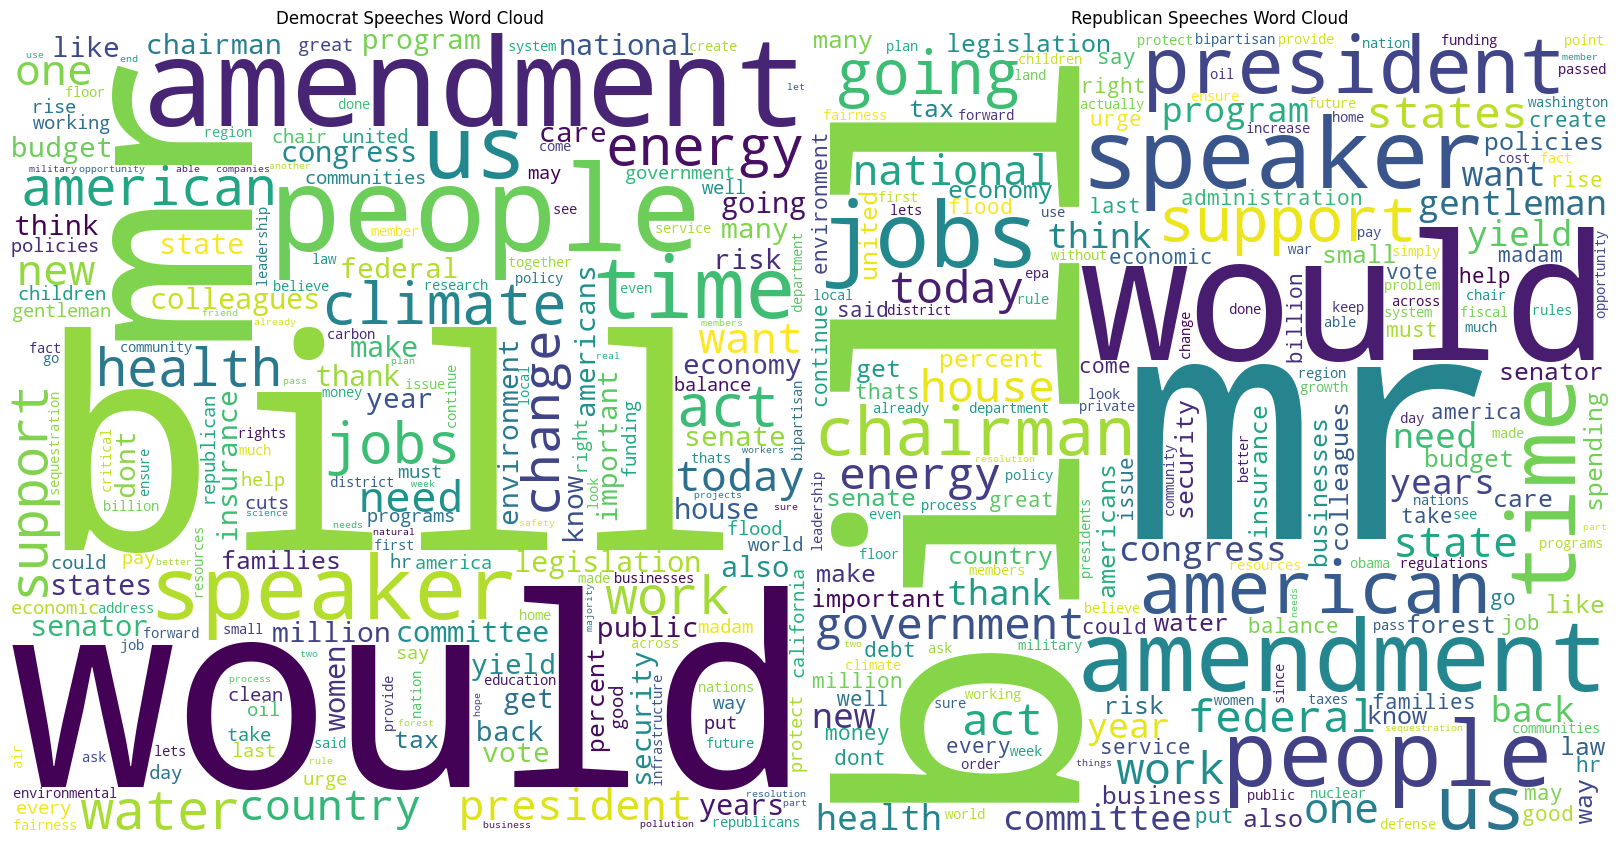

In [25]:
wordcloud_dem = WordCloud(width=800, height=800, background_color='white')
wordcloud_dem.generate_from_frequencies(dict(democrat_word_scores))

wordcloud_rep = WordCloud(width=800, height=800, background_color='white')
wordcloud_rep.generate_from_frequencies(dict(republican_word_scores))

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_dem, interpolation='bilinear')
plt.title('Democrat Speeches Word Cloud')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_rep, interpolation='bilinear')
plt.title('Republican Speeches Word Cloud')
plt.axis("off")

plt.tight_layout(pad=0)
plt.show()

### Word cloud analysis of the climate filtered Hansard


**Calculating the Labour and Conservative TF-IDF scores for the cleaned tokens in Hansard**


In [26]:
labour_speeches = climate_hansard[climate_hansard['speech_party']
                                  == 'Labour']['cleaned_tokens']
conservative_speeches = climate_hansard[climate_hansard['speech_party']
                                        == 'Conservative']['cleaned_tokens']

labour_word_scores = get_sorted_word_scores(labour_speeches)
conservative_word_scores = get_sorted_word_scores(conservative_speeches)

**Creating word clouds for the Labour and Conservative TF-IDF scores**


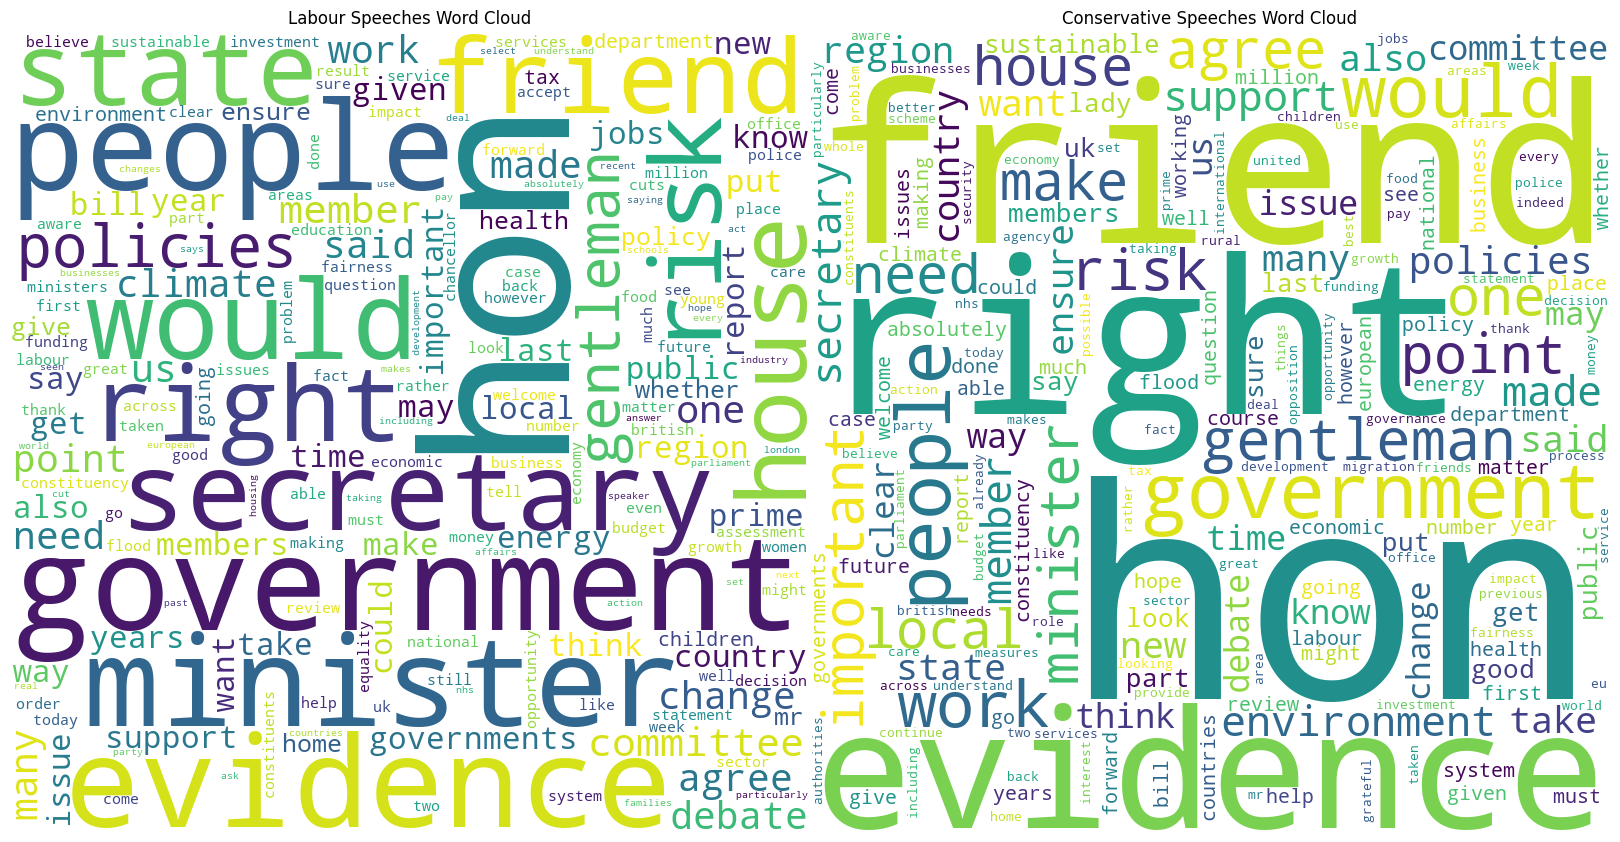

In [27]:
wordcloud_lab = WordCloud(width=800, height=800, background_color='white')
wordcloud_lab.generate_from_frequencies(dict(labour_word_scores))

wordcloud_con = WordCloud(width=800, height=800, background_color='white')
wordcloud_con.generate_from_frequencies(dict(conservative_word_scores))

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_lab, interpolation='bilinear')
plt.title('Labour Speeches Word Cloud')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_con, interpolation='bilinear')
plt.title('Conservative Speeches Word Cloud')
plt.axis("off")

plt.tight_layout(pad=0)
plt.show()

## Embeddings analysis


Word embeddings are used to investigate the first two hypotheses:

- Hypothesis 1: Labour and Conservative politicians should not exhibit a semantic distinction in the language they use to discuss climate change.
- Hypothesis 2: Democratic and Republican politicians should exhibit a widening semantic distinction in the language they use to discuss climate change.


In [28]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

climate_congressional_record = pd.read_csv(
    data_path + 'climate_congressional_record.csv')
climate_hansard = pd.read_csv(data_path + 'climate_hansard.csv')

### Embedding the climate filtered Congressional Record


In [40]:
cleaned_tokens = climate_congressional_record['cleaned_tokens'].tolist()

climate_congressional_record_embeddings = model.encode(
    cleaned_tokens, show_progress_bar=True)
np.save(data_path + 'climate_congressional_record_embeddings.npy',
        climate_congressional_record_embeddings)

Batches: 100%|██████████| 573/573 [01:54<00:00,  4.99it/s]


### Embedding the climate filtered Hansard


In [41]:
cleaned_tokens = climate_hansard['cleaned_tokens'].tolist()

climate_hansard_embeddings = model.encode(
    cleaned_tokens, show_progress_bar=True)
np.save(data_path + 'climate_hansard_embeddings.npy',
        climate_hansard_embeddings)

Batches: 100%|██████████| 1031/1031 [00:59<00:00, 17.31it/s]


### Visualizing the embeddings


In [53]:
np.random.seed(42)
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')

**Visualising the US embeddings by party**


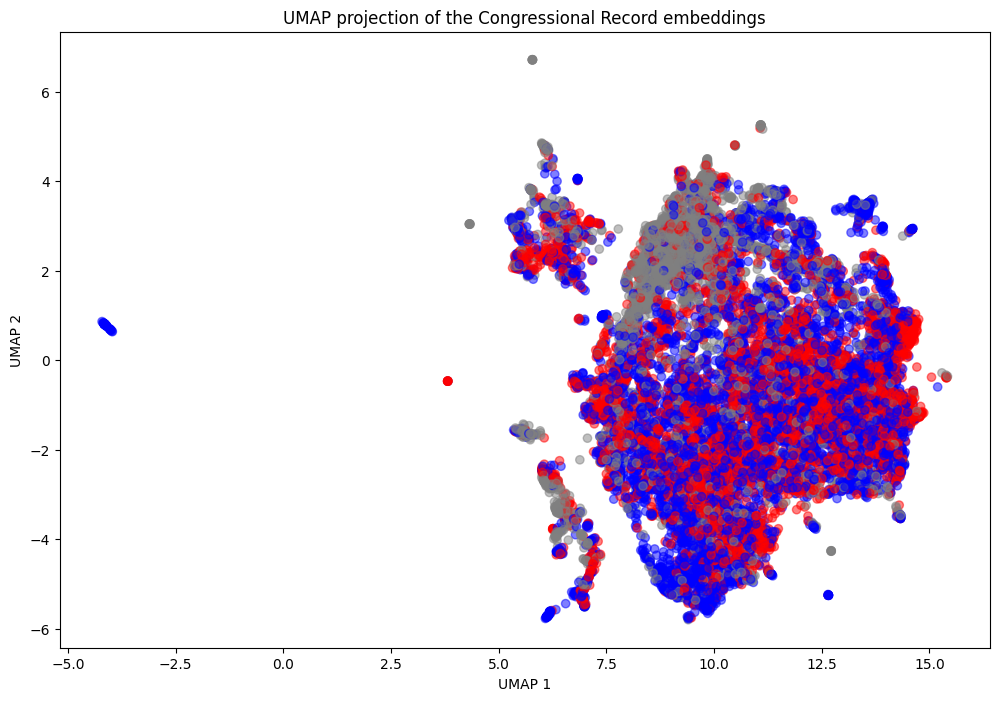

In [54]:
climate_congressional_record_embeddings = np.load(
    data_path + 'climate_congressional_record_embeddings.npy')

umap_embeddings = umap_model.fit_transform(
    climate_congressional_record_embeddings)

party_colors = {
    'R': 'red',
    'D': 'blue'
}
default_color = 'grey'
colors = climate_congressional_record['party'].apply(
    lambda x: party_colors.get(x, default_color))

plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], alpha=0.5, c=colors)
plt.title('UMAP projection of the Congressional Record embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

**Visualising the UK embeddings by party**


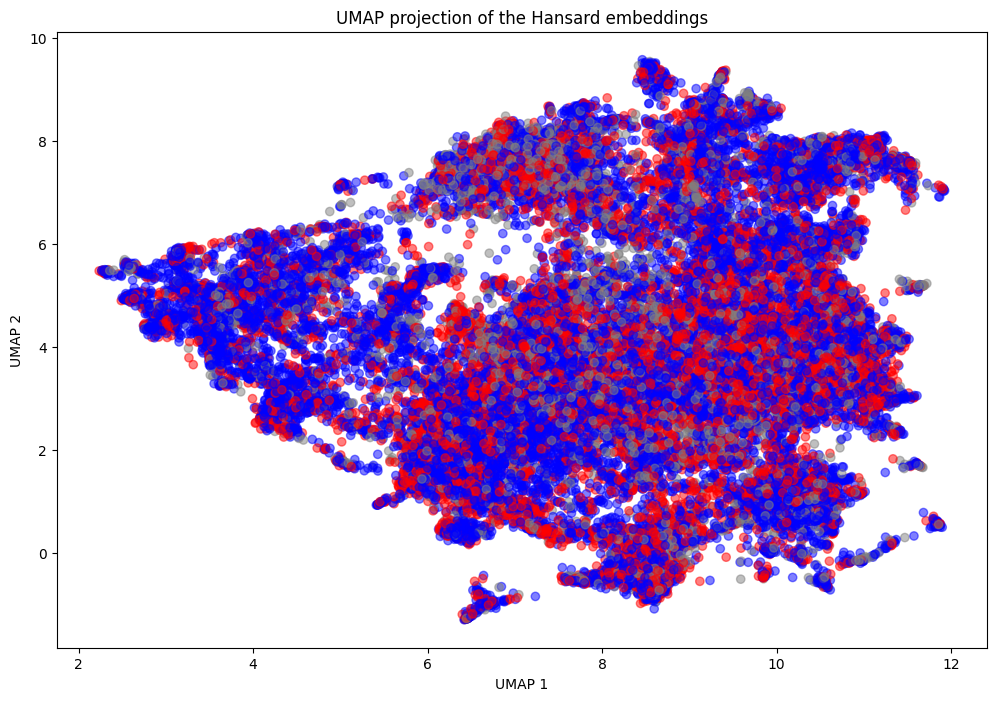

In [55]:
climate_hansard_embeddings = np.load(
    data_path + 'climate_hansard_embeddings.npy')

umap_embeddings = umap_model.fit_transform(climate_hansard_embeddings)

party_colors = {
    'Conservative': 'blue',
    'Labour': 'red'
}
default_color = 'grey'
colors = climate_hansard['speech_party'].apply(
    lambda x: party_colors.get(x, default_color))

plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], alpha=0.5, c=colors)
plt.title('UMAP projection of the Hansard embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

**Comparing UK and US embeddings**


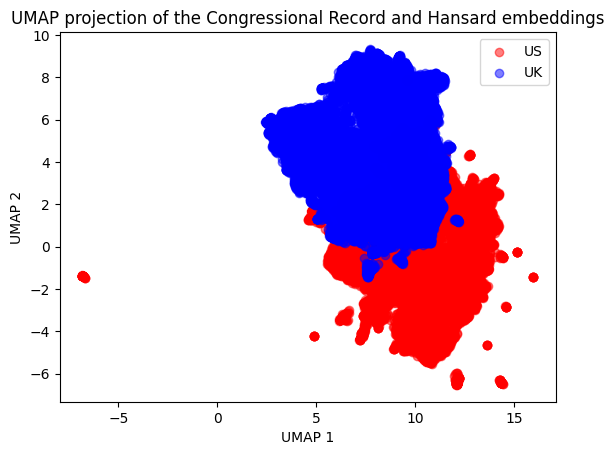

In [56]:
climate_congressional_record_embeddings = np.load(
    data_path + 'climate_congressional_record_embeddings.npy')
climate_hansard_embeddings = np.load(
    data_path + 'climate_hansard_embeddings.npy')

umap_congressional_record_embeddings = umap_model.fit_transform(
    climate_congressional_record_embeddings)
umap_hansard_embeddings = umap_model.fit_transform(climate_hansard_embeddings)

plt.scatter(umap_congressional_record_embeddings[:, 0],
            umap_congressional_record_embeddings[:, 1], alpha=0.5, c='red', label='US')
plt.scatter(umap_hansard_embeddings[:, 0],
            umap_hansard_embeddings[:, 1], alpha=0.5, c='blue', label='UK')
plt.title('UMAP projection of the Congressional Record and Hansard embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

**Comparing the UK Labour and the US Democratic embeddings**


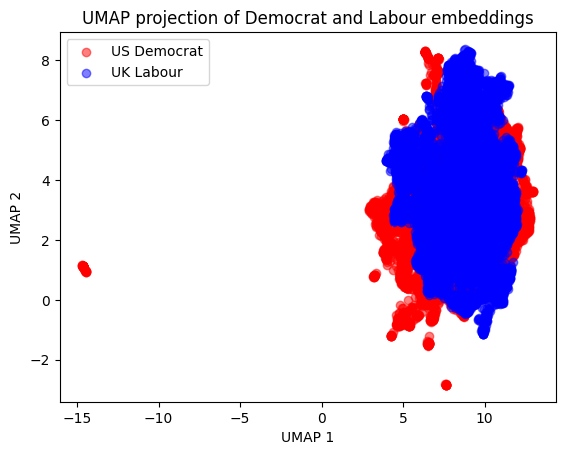

In [60]:
climate_congressional_record = pd.read_csv(
    data_path + 'climate_congressional_record.csv')
climate_hansard = pd.read_csv(data_path + 'climate_hansard.csv')

us_democrat_mask = (climate_congressional_record['party'] == 'D')
uk_labour_mask = (climate_hansard['speech_party'] == 'Labour')

climate_congressional_record_embeddings = np.load(
    data_path + 'climate_congressional_record_embeddings.npy')
climate_hansard_embeddings = np.load(
    data_path + 'climate_hansard_embeddings.npy')

us_democrat_embeddings = climate_congressional_record_embeddings[us_democrat_mask]
uk_labour_embeddings = climate_hansard_embeddings[uk_labour_mask]

umap_us_democrat_embeddings = umap_model.fit_transform(us_democrat_embeddings)
umap_uk_labour_embeddings = umap_model.fit_transform(uk_labour_embeddings)

plt.scatter(umap_us_democrat_embeddings[:, 0],
            umap_us_democrat_embeddings[:, 1], alpha=0.5, c='red', label='US Democrat')
plt.scatter(umap_uk_labour_embeddings[:, 0],
            umap_uk_labour_embeddings[:, 1], alpha=0.5, c='blue', label='UK Labour')
plt.title('UMAP projection of Democrat and Labour embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

**Comparing the UK Conservative and the US Republican embeddings**


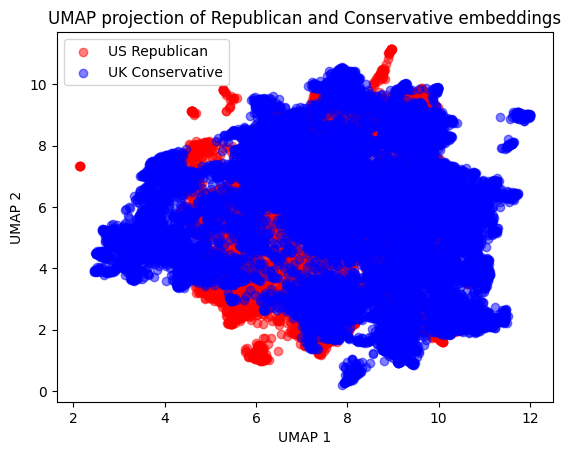

In [61]:
climate_congressional_record = pd.read_csv(
    data_path + 'climate_congressional_record.csv')
climate_hansard = pd.read_csv(data_path + 'climate_hansard.csv')

us_republican_mask = (climate_congressional_record['party'] == 'R')
uk_conservative_mask = (climate_hansard['speech_party'] == 'Conservative')

climate_congressional_record_embeddings = np.load(
    data_path + 'climate_congressional_record_embeddings.npy')
climate_hansard_embeddings = np.load(
    data_path + 'climate_hansard_embeddings.npy')

us_republican_embeddings = climate_congressional_record_embeddings[us_republican_mask]
uk_conservative_embeddings = climate_hansard_embeddings[uk_conservative_mask]

umap_us_republican_embeddings = umap_model.fit_transform(
    us_republican_embeddings)
umap_uk_conservative_embeddings = umap_model.fit_transform(
    uk_conservative_embeddings)

plt.scatter(umap_us_republican_embeddings[:, 0],
            umap_us_republican_embeddings[:, 1], alpha=0.5, c='red', label='US Republican')
plt.scatter(umap_uk_conservative_embeddings[:, 0],
            umap_uk_conservative_embeddings[:, 1], alpha=0.5, c='blue', label='UK Conservative')
plt.title('UMAP projection of Republican and Conservative embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()